In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 24 days
Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 24 days


In [2]:
import theano
import theano.tensor.signal.downsample
from theano.tensor.shared_randomstreams import RandomStreams

#note: this requires the starter code for the assignments!
from common.plotting import plot_mat

Using gpu device 0: GeForce GTX 780


Building dataset:

[Customizable: trainset size]

Initializing all data picking train/validation sets ratio

In [3]:
from fuel.datasets.cifar10 import CIFAR10
from fuel.transformers import ScaleAndShift, Cast, Flatten, Mapping
from fuel.streams import DataStream
from fuel.schemes import SequentialScheme, ShuffledScheme

CIFAR10.default_transformers = (
    (ScaleAndShift, [2.0 / 255.0, -1], {'which_sources': 'features'}),
    (Cast, [np.float32], {'which_sources': 'features'}))

#trainset [0,50k]
trainset=40000
cifar_train = CIFAR10(("train",), subset=slice(None,trainset))

#this stream will shuffle the MNIST set and return us batches of 100 examples
cifar_train_stream = DataStream.default_stream(
    cifar_train,
    iteration_scheme=ShuffledScheme(cifar_train.num_examples, 25))
cifar_validation = CIFAR10(("train",), subset=slice(trainset, None))

# We will use larger portions for testing and validation
# as these dont do a backward pass and reauire less RAM.
cifar_validation_stream = DataStream.default_stream(
    cifar_validation, iteration_scheme=SequentialScheme(cifar_validation.num_examples, 25))
cifar_test = CIFAR10(("test",))
cifar_test_stream = DataStream.default_stream(
    cifar_test, iteration_scheme=SequentialScheme(cifar_test.num_examples, 25))

print "The streams return batches containing %s" % (cifar_train_stream.sources,)

print "Each trainin batch consits of a tuple containing:"
for element in next(cifar_train_stream.get_epoch_iterator()):
    print " - an array of size %s containing %s" % (element.shape, element.dtype)
    
print "Validation/test batches consits of tuples containing:"
for element in next(cifar_test_stream.get_epoch_iterator()):
    print " - an array of size %s containing %s" % (element.shape, element.dtype)

The streams return batches containing (u'features', u'targets')
Each trainin batch consits of a tuple containing:
 - an array of size (25, 3, 32, 32) containing float32
 - an array of size (25, 1) containing uint8
Validation/test batches consits of tuples containing:
 - an array of size (25, 3, 32, 32) containing float32
 - an array of size (25, 1) containing uint8


In [4]:
#
# These are taken from https://github.com/mila-udem/blocks
# 

class Constant():
    """Initialize parameters to a constant.
    The constant may be a scalar or a :class:`~numpy.ndarray` of any shape
    that is broadcastable with the requested parameter arrays.
    Parameters
    ----------
    constant : :class:`~numpy.ndarray`
        The initialization value to use. Must be a scalar or an ndarray (or
        compatible object, such as a nested list) that has a shape that is
        broadcastable with any shape requested by `initialize`.
    """
    def __init__(self, constant):
        self._constant = numpy.asarray(constant)

    def generate(self, rng, shape):
        dest = numpy.empty(shape, dtype=np.float32)
        dest[...] = self._constant
        return dest


class IsotropicGaussian():
    """Initialize parameters from an isotropic Gaussian distribution.
    Parameters
    ----------
    std : float, optional
        The standard deviation of the Gaussian distribution. Defaults to 1.
    mean : float, optional
        The mean of the Gaussian distribution. Defaults to 0
    Notes
    -----
    Be careful: the standard deviation goes first and the mean goes
    second!
    """
    def __init__(self, std=1, mean=0):
        self._mean = mean
        self._std = std

    def generate(self, rng, shape):
        m = rng.normal(self._mean, self._std, size=shape)
        return m.astype(np.float32)


class Uniform():
    """Initialize parameters from a uniform distribution.
    Parameters
    ----------
    mean : float, optional
        The mean of the uniform distribution (i.e. the center of mass for
        the density function); Defaults to 0.
    width : float, optional
        One way of specifying the range of the uniform distribution. The
        support will be [mean - width/2, mean + width/2]. **Exactly one**
        of `width` or `std` must be specified.
    std : float, optional
        An alternative method of specifying the range of the uniform
        distribution. Chooses the width of the uniform such that random
        variates will have a desired standard deviation. **Exactly one** of
        `width` or `std` must be specified.
    """
    def __init__(self, mean=0., width=None, std=None):
        if (width is not None) == (std is not None):
            raise ValueError("must specify width or std, "
                             "but not both")
        if std is not None:
            # Variance of a uniform is 1/12 * width^2
            self._width = numpy.sqrt(12) * std
        else:
            self._width = width
        self._mean = mean

    def generate(self, rng, shape):
        w = self._width / 2
        m = rng.uniform(self._mean - w, self._mean + w, size=shape)
        return m.astype(np.float32)

In [5]:
rng = np.random.RandomState(1234)
srng = theano.tensor.shared_randomstreams.RandomStreams(rng.randint(999999))
class Layer_ReLU():
    "Creates ReLU layer"
    def __init__(self):
        pass
    def apply(self,input_tensor,name):
        return [None,None,theano.tensor.maximum(0.0,input_tensor)]

class Layer_Conv():
    def __init__(self,num_filters,filter_size,init_weight=None,padding=0):
            self.num_filters=num_filters
            self.filter_size=filter_size
            self.padding=padding
            if init_weight is not None:
                self.init_weight=init_weight
            else:
                 self.init_weight=0.01
    
    def apply(self,input_tensor,name):
        
        CW = theano.shared(np.zeros((self.num_filters,input_tensor.tag.test_value.shape[1],self.filter_size,self.filter_size),
                                    dtype='float32'),name='CW'+name)
        CW.tag.initializer= IsotropicGaussian(self.init_weight)
        CB = theano.shared(np.zeros((self.num_filters), dtype='float32'),
                    name='CB'+name)
        CB.tag.initializer = Constant(0.0)
        output_tensor = theano.tensor.nnet.conv2d(input_tensor, CW) + CB.dimshuffle('x',0,'x','x')
        return [CW,CB,output_tensor]

class Layer_MaxPool():
    def __init__(self,ds,st=None):
        self.ds=ds
        if st is not None:
            self.st=st
        else:
            self.st=ds
    
    def apply(self,input_tensor,name):
        return [None,None,theano.tensor.signal.downsample.max_pool_2d(input_tensor,ds=self.ds,st=self.st,ignore_border=True)]
##Doesn't improve anything
class Layer_LocalRespNorm():
    def __init__(self, alpha = 1e-4, k=1, beta=0.75, n=5):
        self.alpha=alpha
        self.k=k;
        self.beta=beta;
        self.n=n;


    def apply(self, input_tensor,name):
        half = self.n // 2
        input_squared=input_tensor**2
        d0, d1, d2, d3 = input_tensor.shape
        padded_input = theano.tensor.alloc(0., d0, d1+2*half, d2, d3)
        input_squared = theano.tensor.set_subtensor(padded_input[:,half:half+d1,:,:], input_squared)
        scale = theano.tensor.tensor4('S')
        scale=input_tensor
        #theano.tensor.mean(input_tensor, keepdims=True)
        for i in xrange(self.n):
            for j in xrange(self.n):
                temporar=input_squared[:,i:i+d1,:,:]
                scale += self.alpha * input_tensor[:,:,:]#input_squared[:,:,i:i+d2,j:j+d3]

        
        scale = scale ** self.beta

        return [None,None,input_tensor / scale]

class Flatten():
    def __init__(self):
        pass
    def apply(self,input_tensor):
        return theano.tensor.flatten(input_tensor,2)

##Doesn't improve anything
class Layer_Dropout():
    def __init__(self,drop_probab):
        self.p=drop_probab
        self.train_on=True
    def apply(self,input_tensor,name,train_on):
        inp_shape=input_tensor.tag.test_value.shape
        print inp_shape
        mask = srng.binomial(n=1, p=(1-self.p), size=(inp_shape[1],inp_shape[2]), dtype='float32')
        mask=theano.shared(mask,name='Dmask'+name)
        #print numpy.asarray(srng.uniform(0.0,1.0,(inp_shape[1],inp_shape[2]))>=self.p,dtype='float32')
        
        train_tensor=input_tensor*mask.dimshuffle('x',0)
        output_tensor= theano.tensor.switch(theano.tensor.neq(train_on, 0), train_tensor, (1.-self.p)*input_tensor)
        return[None,None,output_tensor]

class Layer_BatchNorm():
    def __init__(self):
        pass
    def apply(self,input_tensor,name):
        mean=theano.tensor.mean(input_tensor,axis=(0,2,3),keepdims=True)
        std=theano.tensor.std(input_tensor,axis=(0,2,3),keepdims=True)
        inp_shape=input_tensor.tag.test_value.shape
        BNW = theano.shared(np.zeros(inp_shape[1],
                                    dtype='float32'),name='BNW'+name)
        BNW.tag.initializer= Constant(1)
        BNB = theano.shared(np.zeros((inp_shape[1]), dtype='float32'),
                    name='BNW'+name)
        BNB.tag.initializer = IsotropicGaussian(0.01)
        output_tensor=BNW.dimshuffle('x',0,'x','x')/(std+1e-3)*(input_tensor-mean)+BNB.dimshuffle('x',0,'x','x')
        return [BNW,BNB,output_tensor]

class Layer_RGBtoYUV():
    def __init(self):
        pass
    
    def apply(self,input_tensor,name):
        r = input_tensor[:, 0, :, :]
        g = input_tensor[:, 1, :, :]
        b = input_tensor[:, 2, :, :]

        y = 0.299 * r + 0.587 * g + 0.114 * b
        u = -0.14713 * r - 0.28886 * g + 0.436 * b
        v = 0.615 * r - 0.51499 * g - 0.10001 * b
        
        input_tensor = theano.tensor.set_subtensor(input_tensor[:, 0, :, :], y)
        input_tensor = theano.tensor.set_subtensor(input_tensor[:, 1, :, :], u)
        input_tensor = theano.tensor.set_subtensor(input_tensor[:, 2, :, :], v)
        output_tensor=input_tensor
        return [None,None,output_tensor]
class Layer_Flip(): 
    def __init__(self,prob=0.2):
        self.prob=prob
        self.train_on=True
    
    def apply(self,input_tensor,name,train_on):
        rv_u = srng.binomial(n=1,p=self.prob,size=(1,)).astype('float32')
        f=theano.function([],rv_u)
        coef=f()
        train_tensor=input_tensor[:,:,:,::-1]*coef+(1-coef)*input_tensor
        output_tensor= theano.tensor.switch(theano.tensor.neq(train_on, 0), train_tensor, input_tensor)
        return [None,None,output_tensor]

class Layer_GaussB(): 
    def __init__(self,filter_size,std=1.0):
        self.std=std
        self.filter_size=filter_size
        self.train_on=True
    
    def apply(self,input_tensor,name):
        half=self.filter_size//2
        x = np.arange(-half,half+1)
        y = np.arange(-half,half+1)
        inp_shape=input_tensor.tag.test_value.shape
        z = np.arange(0,inp_shape[1])
        w = np.arange(0,inp_shape[1])
        Z,W,X,Y=np.meshgrid(z,w,x,y)
        gaussian=np.exp(-(X**2+Y**2)/(2*self.std**2))
        gaussian=(inp_shape[1]**2*gaussian/np.sum(gaussian.reshape(-1))).astype(np.float32)
        #print gaussian
        G_kernel = theano.shared(gaussian)
        train_tensor=theano.tensor.nnet.conv2d(input_tensor,G_kernel,border_mode='full')
        output_tensor= theano.tensor.switch(theano.tensor.neq(train_on, 0), train_tensor, input_tensor)
        return [None,None,output_tensor]

class Layer_FullyCon():
    def __init__(self,hidden_neurons,init_weight=None):
        self.hidden_neurons=hidden_neurons
        if init_weight is not None:
            self.init_weight=init_weight
        else:
             self.init_weight=0.01
        
    def apply(self,input_tensor,name):
        if input_tensor.tag.test_value.ndim!=2:
            input_tensor=Flatten().apply(input_tensor)
        
        FW=theano.shared(np.zeros((input_tensor.tag.test_value.shape[1], self.hidden_neurons), dtype='float32'),
                   name='FW'+name)
        FW.tag.initializer = IsotropicGaussian(self.init_weight)
        FB = theano.shared(np.zeros((self.hidden_neurons,), dtype='float32'),
                    name='FB'+name)
        FB.tag.initializer = Constant(0.0)
        return [FW,FB,theano.tensor.dot(input_tensor,FW)+FB.dimshuffle('x',0)]
    
class Layer_SoftMax():
    "Creates Softmax Layer"
    def __init__(self):
        pass
    def apply(self,input_tensor,name):
        return [None,None,theano.tensor.nnet.softmax(input_tensor)]

In [6]:
class Network():
    def __init__(self,layers,X_test_value,train_on_value):
        self.layers=layers
        self.X_test_value=X_test_value
        self.train_on_value=train_on_value
    def apply(self,X,train_on):
        model_parameters = []
        X.tag.test_value=self.X_test_value
        train_on.tag.test_value=self.train_on_value
        for inx, layer in enumerate(self.layers):
            name=str(inx)
            if hasattr(layer,'train_on'):
                FM,FB,newX=layer.apply(X,name,train_on)
            else:
                FM,FB,newX=layer.apply(X,name)
            X=newX
            print "New X shape: %s" % (X.tag.test_value.shape,)
            if FM is not None:
                model_parameters+= [FM,FB]
        return X,model_parameters
            
            

In [7]:
# A theano variable is an entry to the cmputational graph
# We will need to provide its value during function call
# X is batch_size x num_channels x img_rows x img_columns
X = theano.tensor.tensor4('X')
train_on =theano.tensor.iscalar('train_on') 
# Y is 1D, it lists the targets for all examples
Y = theano.tensor.matrix('Y', dtype='uint8')

#The tag values are useful during debugging the creation of Theano graphs

X_test_value, Y_test_value = next(cifar_train_stream.get_epoch_iterator())
#
# Unfortunately, test tags don't work with convolutions with newest Theano :(
#
theano.config.compute_test_value = 'raise' # Enable the computation of test values
Y.tag.test_value = Y_test_value
train_on.tag.test_value=1
# this list will hold all parameters of the network

model_parameters = []
theano.config.on_unused_input='ignore'
CNN=Network(
    [
     Layer_RGBtoYUV(),
     Layer_Conv(32,5,0.001),
     Layer_ReLU(),
     Layer_MaxPool((2,2)),
     Layer_BatchNorm(),
     Layer_Conv(64,5,0.001),
     Layer_ReLU(),
     Layer_MaxPool((2,2)),
     Layer_BatchNorm(),
     Layer_Conv(128,5,0.01),
     Layer_ReLU(),
     Layer_FullyCon(512,0.05),
     Layer_SoftMax()
        
    ],X_test_value,1)
log_probs,model_parameters = CNN.apply(X,train_on)
predictions =theano.tensor.argmax(log_probs, axis=1)
error_rate = theano.tensor.neq(predictions,Y.ravel()).mean()
nll = - theano.tensor.log(log_probs[theano.tensor.arange(Y.shape[0]), Y.ravel()]).mean()

weight_decay = 0.0
for p in model_parameters:
    if p is not None  and p.name[1]=='W':
        weight_decay = weight_decay + 1e-3 * (p**2).sum()

cost = nll + weight_decay

#At this point stop computing test values
theano.config.compute_test_value = 'off' # Enable the computation of test values

New X shape: (25, 3, 32, 32)
New X shape: (25, 32, 28, 28)
New X shape: (25, 32, 28, 28)
New X shape: (25, 32, 14, 14)
New X shape: (25, 32, 14, 14)
New X shape: (25, 64, 10, 10)
New X shape: (25, 64, 10, 10)
New X shape: (25, 64, 5, 5)
New X shape: (25, 64, 5, 5)
New X shape: (25, 128, 1, 1)
New X shape: (25, 128, 1, 1)
New X shape: (25, 512)
New X shape: (25, 512)


In [8]:
updates = []
lrate = theano.tensor.scalar('lrate',dtype='float32')
momentum = theano.tensor.scalar('momentum',dtype='float32')

# Theano will compute the gradients for us
gradients = theano.grad(cost, model_parameters)

#initialize storage for momentum
velocities = [theano.shared(np.zeros_like(p.get_value()), name='V_%s' %(p.name, )) for p in model_parameters]

for p,g,v in zip(model_parameters, gradients, velocities):
    v_new = momentum * v - lrate * g
    p_new = p + v_new
    updates += [(v,v_new), (p, p_new)]


In [9]:
#compile theano functions

#each call to train step will make one SGD step
train_step = theano.function([X,Y,train_on,lrate,momentum],[cost, error_rate, nll, weight_decay],updates=updates)
#each call to predict will return predictions on a batch of data
predict = theano.function([X,train_on], predictions)

In [10]:
def compute_error_rate(stream):
    errs = 0.0
    num_samples = 0.0
    for X, Y in stream.get_epoch_iterator():
        errs += (predict(X,0)!=Y.ravel()).sum()
        num_samples += Y.shape[0]
    return errs/num_samples


In [11]:
#utilities to save values of parameters and to load them

def init_parameters():
    rng = np.random.RandomState(1234)
    for p in model_parameters:
        p.set_value(p.tag.initializer.generate(rng, p.get_value().shape))

def snapshot_parameters():
    return [p.get_value(borrow=False) for p in model_parameters]

def load_parameters(snapshot):
    for p, s in zip(model_parameters, snapshot):
        p.set_value(s, borrow=False)

In [12]:
# init training

i=0
e=0

init_parameters()
for v in velocities:
    v.set_value(np.zeros_like(v.get_value()))

best_valid_error_rate = np.inf
best_params = snapshot_parameters()
best_params_epoch = 0

train_erros = []
train_loss = []
train_nll = []
validation_errors = []

number_of_epochs = 3
patience_expansion = 3

In [13]:
# training loop

while e<number_of_epochs: #This loop goes over epochs
    e += 1
    #First train on all data from this batch
    epoch_start_i = i
    for X_batch, Y_batch in cifar_train_stream.get_epoch_iterator(): 
        i += 1
        #print i
        
        K = 2000
        lrate = 4e-3 #* K / np.maximum(K, i)
        #try 1e-3, 1e-4 after e
        if e>10:
            lrate=1e-4
        if e>20:
            lrate=1e-5
        if e>40:
            lrate=1e-6
        momentum=0.9
        
        L, err_rate, nll, wdec = train_step(X_batch, Y_batch,1, lrate, momentum)
        
        #print [p.get_value().ravel()[:10] for p in model_parameters]
        #print [p.get_value().ravel()[:10] for p in velocities]
        
        
        train_loss.append((i,L))
        train_erros.append((i,err_rate))
        train_nll.append((i,nll))
        if i % 100 == 0:
            print "At minibatch %d, batch loss %f, batch nll %f, batch error rate %f%%" % (i, L, nll, err_rate*100)
        
    # After an epoch compute validation error
    val_error_rate = compute_error_rate(cifar_validation_stream)
    if val_error_rate < best_valid_error_rate:
        number_of_epochs = np.maximum(number_of_epochs, e * patience_expansion+1)
        best_valid_error_rate = val_error_rate
        best_params = snapshot_parameters()
        best_params_epoch = e
    validation_errors.append((i,val_error_rate))
    print "After epoch %d: valid_err_rate: %f%% currently going to do %d epochs" %(
        e, val_error_rate*100, number_of_epochs)

    print "After epoch %d: averaged train_err_rate: %f%% averaged train nll: %f averaged train loss: %f" %(
        e, np.mean(np.asarray(train_erros)[epoch_start_i:,1])*100, 
        np.mean(np.asarray(train_nll)[epoch_start_i:,1]),
        np.mean(np.asarray(train_loss)[epoch_start_i:,1]))


At minibatch 100, batch loss 1.680315, batch nll 1.482210, batch error rate 52.000000%
At minibatch 200, batch loss 1.842325, batch nll 1.642967, batch error rate 56.000000%
At minibatch 300, batch loss 1.841623, batch nll 1.642163, batch error rate 56.000000%
At minibatch 400, batch loss 1.565097, batch nll 1.365087, batch error rate 52.000000%
At minibatch 500, batch loss 1.573486, batch nll 1.373355, batch error rate 52.000000%
At minibatch 600, batch loss 1.610164, batch nll 1.410179, batch error rate 44.000000%
At minibatch 700, batch loss 1.408688, batch nll 1.208551, batch error rate 40.000000%
At minibatch 800, batch loss 1.448850, batch nll 1.248818, batch error rate 36.000000%
At minibatch 900, batch loss 1.628445, batch nll 1.428456, batch error rate 60.000000%
At minibatch 1000, batch loss 1.436950, batch nll 1.236899, batch error rate 48.000000%
At minibatch 1100, batch loss 1.720807, batch nll 1.520697, batch error rate 52.000000%
At minibatch 1200, batch loss 1.282075, b

KeyboardInterrupt: 

Setting network parameters from after epoch 15
Test error rate is 24.930000%


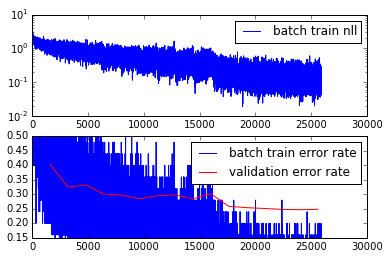

In [14]:
print "Setting network parameters from after epoch %d" %(best_params_epoch)
load_parameters(best_params)

print "Test error rate is %f%%" %(compute_error_rate(cifar_test_stream)*100.0,)

subplot(2,1,1)
train_nll_a = np.array(train_nll)
semilogy(train_nll_a[:,0], train_nll_a[:,1], label='batch train nll')
legend()

subplot(2,1,2)
train_erros_a = np.array(train_erros)

plot(train_erros_a[:,0], train_erros_a[:,1], label='batch train error rate')
validation_errors_a = np.array(validation_errors)
plot(validation_errors_a[:,0], validation_errors_a[:,1], label='validation error rate', color='r')
ylim(0.15,0.5)

In [24]:
pr_errs = 0.0
pr_num_samples = 0.0
arr_ans=[]
arr_corr=[]

for X, Y in cifar_test_stream.get_epoch_iterator():
    pr_errs += (predict(X,0)!=Y.ravel()).sum()
    pr_num_samples += Y.shape[0]
    #print predict(X,0),Y.ravel()
    arr_ans.extend(predict(X,0))
    arr_corr.extend(Y.ravel())

#print pr_errs,pr_num_samples,arr_ans,arr_corr
f = open('results','w')
for x,y in zip(arr_ans,arr_corr):
    f.write('%d %d\n'% (x,y))
f.close()